# Sentiment Analysis (Practice Case)





##### Zumarsiyah Mahsyari
##### Astra Data Scientist Bootcamp

Sentimen Analysis atau opinion mining merupakan metode analisis berbasis komputasi mengenai pendapat, sentimen, dan emosi (Liu, 2010). Analisis sentimen digunakan untuk melihat kecenderungan suatu sentimen atau pendapat terhadap suatu hal yang terjadi, apakah pendapat tersebut cenderung beropini positif atau negatif.
<br> <br>
Pada Practice Case kali ini, kita melakukan Sentiment Analysis menggunakan Data Tweet yang dapat diakses melalui https://bit.ly/316a1iw. Data tersebut berisi kolom text dan target. Kolom text berisi tweet dan kolom target merupakan sentimen dari tweet tersebut, (0 = sentimen negatif dan 1 = sentimen positif). Data terdiri dari 1.600.000 tweet.

Sebelum melakukan sentiment analysis, kita perlu melakukan Praprocessing Data yang meliputi:
1. Lower Casing: menjadikan text berhuruf kecil semua (tidak ada yang huruf kapital)
2. Punctuation Removal: menghapus tanda baca
3. Stopword: mengambil kata-kata yang penting
4. Lemmatization: mengubah kata-kata yang ada menjadi kata yang sesuai dengan kaidahnya

Setelah dilakukan praprocessing data, hal yang perlu kita lakukan selanjutnya adalah melakukan klasifikasi tweet tersebut. Klasifikasi yang dilakukan pada Practice Case kali ini menggunakan algoritma Logistic Regression dan Naive Bayes. Adapun untuk evaluasi model kita menggunakan nilai Akurasi, Recall, Precision, dan F1 Score.

In [1]:
import pandas as pd 
import numpy as np 
import nltk 

#import nltk for natural language toolkit
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords

#import string, regex, , uniqcode
import re, string, unicodedata

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import Word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zumars064124\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load & Read Data

In [42]:
df = pd.read_csv("clean_tweet.csv")
df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


Tabel di atas merupakan data yang kita gunakan. Tabel tersebut terdiri atas 1.600.000 baris dan 2 kolom, yaitu 'text' yang merupakan tweet dan 'target' yang menunjukkan sentimen dari tweet tersebut. 'Tweet' terbaca sebagai data kategori, sedangkan 'target' berbentuk data numerik, seperti output di bawah ini.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


Berdasarkan hasil di atas, terdapat missing value pada 'text'. Karena data 'text' berupa tweet dan tidak mungkin dilakukan imputasi pada missing value, maka data tersebut dihapuskan saja dari dataset. Tweet yang kosong yang tidak berarti apapun juga adalah alasan data ini dihapus.

In [43]:
df = df.dropna(subset = ['text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596753 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1596753 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.5+ MB


Data dengan missing value telah dihapus dan analisis bisa dilanjutkan ke tahap selanjutnya. 

### Preprocessing Data

Data teks merupakan Unstructured Data sehingga perlu dilakukan tahap preprocessing data untuk menyiapkan data menjadi data yang siap dianalisis. Tahapan preprocessing data pada Practice Case kali ini antara lain Lower Casing, Punctuation Removal, Stopword, dan Lematization.

##### Lower Casing and Punctuation Removal

In [44]:
 def preprocessing(text):
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    def remove_between_square_brackets(text):
        return re.sub('-\[[^]]*\]', '', text)
    def denoise_text(text):
        text = strip_html(text)
        text = remove_between_square_brackets(text)
        return text
    def remove_punctuation(text):
        return re.sub(r'[^\w\s]', '', text)
    def remove_non_ascii(text):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    text = remove_non_ascii(text)
    
    return text.lower()

In [45]:
#apply function 
df['text'] = df['text'].progress_apply(preprocessing)

100%|██████████████████████████████████████████████████████████████████████| 1596753/1596753 [06:02<00:00, 4404.54it/s]


In [46]:
df['text'].head()

0    awww that s a bummer you shoulda got david car...
1    is upset that he can t update his facebook by ...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no it s not behaving at all i m mad why am i h...
Name: text, dtype: object

'text' di atas telah berhuruf kecil semua dan tidak terdapat tanda baca lagi.

##### Stopword

Stopword digunakan untuk mengambil kata-kata penting saja pada tiap tweet. Kata-kata penting yang dimaksud adalah kata-kata yang memiliki makna berarti pada satu tweet. Karena bahasa yang kita gunakan adalah bahasa Inggris, maka kita memilih 'English' pada pilihan di function-nya.

In [47]:
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [48]:
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

'Text' di atas sekarang hanya mengandung kata-kata penting saja pada tiap tweetnya. Dapat dilihat pada data dengan tampilan index 3 di atas. Sebelumnya data tersebut adalah 'my whole body feels itchy and like its on fire'. Setelah dilakukan stopword, data tersebut berubah menjadi 'whole body feels itchy like fire'. Beberapa kata hilang seperti 'my', 'and', 'its', dan 'on' karena kata-kata tersebut dianggap sebagai kata-kata yang tidka penting dalam tweet tersebut.

##### Lemmatization

Lemmatization digunakan untuk mengubah kata-kata yang ada menjadi kata yang sesuai dengan kaidahnya.

In [50]:
#lemmatization 
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [52]:
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2      dived many time ball managed save rest go bound
3                      whole body feel itchy like fire
4                                     behaving mad see
Name: text, dtype: object

Beberapa kata pada 'text' telah berubah menjadi kata yang sesuai dengan kaidahnya. Contoh, pada data 'text' dengan index 3 di atas, sebelumnya data tersebut adalah 'whole body feels itchy like fire'. Setelah dilakukan lemmatization, data tersebut berubah menjadi 'whole body feel itchy like fire." Dapat dilihat terdapat perubahan kata ketiga pada data tersebut. Kata yang awalnya 'feels' berubah menjadi 'feel' karena kata 'feel' sesuai dengan kaidah bahasa Inggris.

### Visualization of EDA

Visualisasi yang dilakukan untuk EDA ini menggunakan wordcloud dan barplot.

##### Wordcloud

Wordcloud merupakan representasi grafis dari sebuah dokumen yang dilakukan dengan plotting kata-kata yang sering mencul pada sebuah dokumen pada ruang dua dimensi. Semakin besar ukuran kata menunjukkan semakin besar frekuensi kata tersebut muncul dalam dokumen (Kurniawan, 2017). Wordcloud pada Practice Case ini menunjukkan kata-kata yang paling sering muncul dalam tweet. Berdasarkan kata-kata tersebut, kita bisa mengetahui hal yang sering dibahas oleh publik melalui tweet mereka. mari kita bandingkan wordcloud keseluruhan tweet, tweet dengan sentimen negatif, dan tweet dengan sentimen positif.

Untuk membuat Wordcloud tweet dengan sentimen negatif, kita harus mendefinisikan terlebih dahulu data yang berisi sentimen negatif saja seperti di bawah ini. Hal yang sama juga dilakukan untuk mendapatkan Wordcloud tweet dengan sentimen positif.

In [12]:
#define happy and not happy 
negatif = df.loc[df['target'] == 0]
positif  = df.loc[df['target'] == 1]

Code di bawah ini digunakan untuk membuat keseluruhan teks yang ingin kita buat Wordcloud-nya ke dalam satu paragraf.

In [54]:
#merge all the text into one paragraph
all_ = "".join(df.text.values)
#merge all the text of negative sentiment into one paragraph
all_negatif = "".join(negatif.text.values)
#merge all the text of positive sentiment into one paragraph
all_positif = "".join(positif.text.values)

Code di bawah ini digunakan untuk mengatur tampilan Wordcloud.

In [14]:
#build a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Berikut ini merupakan hasil visualisasi dengan Wordcloud untuk keseluruhan data, tweet yang bersentimen negatif, dan tweet yang bersentimen positif.

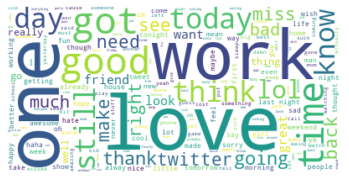

In [55]:
#all
create_word_cloud(all_)

Berdasarkan Wordcloud di atas, dapat diketahui bahwa kata-kata yang sering muncul pada keseluruhan data antara lain 'work', 'love', dan 'one', sehingga dapat diperkirakan bahwa publik banyak membahas terkait hal-hal tersebut melalui twitternya.

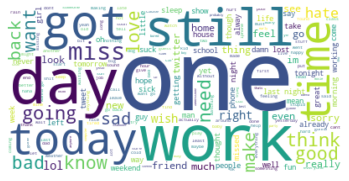

In [15]:
#negative sentiment
create_word_cloud(all_negatif)

Berdasarkan Wordcloud di atas, dapat diketahui bahwa kata-kata yang sering muncul pada keseluruhan data antara lain 'one', 'day', dan 'work', sehingga dapat diperkirakan bahwa publik memiliki sentimen negatif terkait hal-hal tersebut yang dibahas melalui twitternya.

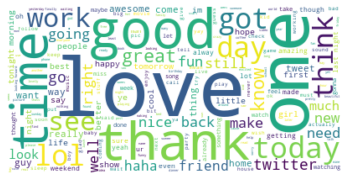

In [16]:
#nothappy
create_word_cloud(all_positif)

Berdasarkan Wordcloud di atas, dapat diketahui bahwa kata-kata yang sering muncul pada keseluruhan data antara lain 'love', 'one', dan 'thank', sehingga dapat diperkirakan bahwa publik memiliki sentimen positif terkait hal-hal tersebut yang dibahas melalui twitternya.

##### Barplot of Tweet Count Based on Target

Mari kita hitung banyaknya 'text' pada data. Karena melakukan visualisasi langsung dari data dengan countplot menggunakan Seaborn membutuhkan waktu yang sangat lama, maka kita membuat tabel baru yang berisi jumlah tweet pada tiap "target" ("tweet_count"). Setelah itu, baru kita membuat barplot menggunakan seaborn berdasarkan tabel tersebut.

In [39]:
#count sentiment 
sentiment = df.groupby(['target'])['target'].count()
sentiment

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['target']
chart.drop(['target'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,target,tweet_count,percent
0,0,798503,0.500079
1,1,798250,0.499921


Setelah kita dapatkan jumlah tweet untup setiap 'target', mari kita buat barplot untuk visualisasinya seperti di bawah ini.

Text(0.5, 1.0, 'Sentiment Class')

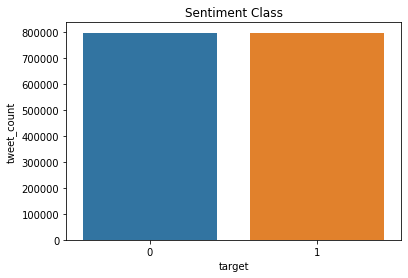

In [40]:
#visualization 
ax = sns.barplot(x= 'target', y='tweet_count', data=chart)
ax.set_title('Sentiment Class')

Berdasarkan visualisasi di atas, dapat disimpulkan bahwa antara tweet yang memiliki sentimen negatif dan tweet yang memiliki sentimen positif proporsinya seimbang. Mari kita beralih ke tahap Praprocessing Data.

## B. Feature Extraction

Feature Extraction yang dilakukan adalah count Vectorizer dan TF-IDF Vectorizer seperti di bawah ini.

### 1. Count Vectorizer 

Count Vectorizer adalah metode untuk ekstraksi data teks yang dilakukan dengan menghitung jumlah tiap kata yang ada dari keseluruhan teks atau dokumen.

In [17]:
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### 2. TF-IDF vectorizer 

TF-IDF vectorize adalah metode pembobotan yang dilakukan untuk ekstraksi data teks. Tujuan dari TF-IDF adalah untuk menemukan jumlah kata yang diketahui (tf) setelah dikalikan dengan beberapa banyak tweet dimana suatu kata tersebut muncul (idf).

In [18]:
tfidf = TfidfVectorizer(stop_words='english' )
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

## C. Modeling 

Setelah melakukan feature extraction, mari kita lanjutkan ke tahap modelling. Karena kita akan melaukan klasifikasi, maka kita perlu membagi data menjadi training data dan testing data dengan perbandingan 80:20. Selanjutnya data diklasifikasi menggunakan algoritma Regresi Logistic dan Naive Bayes. Evaluasi model yang digunakan adalah akurasi, recall, precision, dan F-1 score.

### 1. Train Test Split

Untuk kebutuhan analisis selanjutnya, kita perlu mendefnisikan terlebih dahulu variabel prediktor (X) maupun variabel respon/variabel yang menjadi target kelas (y) seperti code di bawah ini; X adalah 'text' dan y adalah 'target'.

In [19]:
X = df['text']
y = df['target']

Setelah itu kita transformasi datanya berdasarkan Count Vectorizer dan TF_IDF.

In [20]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

Selanjutnya, data siap dibagi menjadi training data dan testing data seperti di bawah ini.

In [21]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

### 2. Model Machine Learning

Model machine learning yang digunakan untuk klasifikasi kali ini menggunakan algoritma Logistic Regression dan Naive Bayes. Masing-masing algoritma membangun model berdasarkan Count Vectorizer dan TF-IDF.

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#### a. Logistic Regression

Regresi logistik adalah suatu metode klasifikasi menggunakan model regresi di mana variabel responnya berupa data kategori.

Code untuk pembentukan model regresi logistik berdasarkan Count Vectorizer adalah sebagai berikut.

In [23]:
# Countvectorizer 
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)

C:\Users\zumars064124\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Code untuk pembentukan model regresi logistik berdasarkan TF-IDF Vectorizer adalah sebagai berikut.

In [24]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

##### Model Evaluation

Model evaluation bertujuan untuk melihat seberapa baik model yang telah terbentuk. Selain itu, apabila evaluasi model antara training dan testing tidak begitu jauh, maka model tersebut telah fit atau baik. Berikut merupakan hasil evalusi model untuk regresi logistik berdasarkan Count Vectorizer dan TF-IDF.

In [61]:
# using count vectorizer
print("______________ Countvectorizer ______________")

Lr_accuracy_vec_train = accuracy_score(train_y, Lr_pred_vect_train)
Lr_accuracy_vec_test = accuracy_score(test_y, Lr_pred_vect_test)

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train, average="micro")
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test,average="micro") 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train,average="micro")
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test,average="micro")

print('Information :')
print('Accuracy train & test     : %.2f%%' % (Lr_accuracy_vec_train * 100), '&', '%.2f%%' % (Lr_accuracy_vec_test * 100))
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Accuracy train & test     : 80.25% & 76.98%
Recall train & test     : 80.25% & 76.98%
Precision train & test  : 80.25% & 76.98%
F1 Score train & test   : 80.25% & 76.98%


Berdasarkan hasil di atas, diketahui nilai akurasi, recall, presicion, dan F-1 score untuk training data sebesar 80,25% sedangkan untuk testing data sebesar 76,98%. Hal ini menunjukkan bahwa model regresi logistik berdasarkan Count Vectorizer telah baik dan dapat digunakan untuk klasifikasi selanjutnya.

In [34]:
# using TF-IDF
print("______________ TF-IDF ______________")

Lr_accuracy_tfidf_train = accuracy_score(train_y, Lr_pred_tfidf_train)
Lr_accuracy_tfidf_test = accuracy_score(test_y, Lr_pred_tfidf_test)

Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Accuracy train & test     : %.2f%%' % (Lr_accuracy_tfidf_train * 100), '&', '%.2f%%' % (Lr_accuracy_tfidf_test * 100))
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Accuracy train & test     : 79.48% & 77.12%
Recall train & test     : 79.48% & 77.12%
Precision train & test  : 79.48% & 77.12%
F1 Score train & test   : 79.48% & 76.98%


Berdasarkan hasil di atas, diketahui nilai akurasi, recall, presicion, dan F-1 score untuk training data sebesar 79,48% sedangkan untuk testing data sebesar 77,12%. Hal ini menunjukkan bahwa model regresi logistik berdasarkan TF-IDF telah baik dan dapat digunakan untuk klasifikasi selanjutnya.

#### b. Naive Bayes Classifier

Teorema Bayes merupakan teorema yang mengacu pada konsep probabilitas bersyarat. Algoritma Naïve Bayes Classifier (NBC) merupakan algoritma yang digunakan untuk mencari nilai probabilitas tertinggi untuk mengklasifikasi data uji pada kategori yang paling tepat.

Code untuk pembentukan model Naïve Bayes Classifier berdasarkan Count Vectorizer adalah sebagai berikut.

In [27]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

Code untuk pembentukan model berdasarkan TF-IDF Vectorizer adalah sebagai berikut.

In [28]:
# TFIDFVectorizer
#from sklearn.naive_bayes import GaussianNB
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

##### Model Evaluation

Berikut merupakan hasil evalusi model untuk Naïve Bayes Classifier berdasarkan Count Vectorizer dan TF-IDF.

In [56]:
# find model evaluation for naive bayes
# using count vectorizer
print("______________ Countvectorizer ______________")

NB_accuracy_vec_train = accuracy_score(train_y, NB_pred_vect_train)
NB_accuracy_vec_test = accuracy_score(test_y, NB_pred_vect_test) 

NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

print('Information :')
print('Accuracy train & test     : %.2f%%' % (NB_accuracy_vec_train * 100), '&', '%.2f%%' % (NB_accuracy_vec_test * 100))
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Accuracy train & test     : 79.08% & 76.20%
Recall train & test     : 79.08% & 76.20%
Precision train & test  : 79.08% & 76.20%
F1 Score train & test   : 79.08% & 76.20%


Berdasarkan hasil di atas, diketahui nilai akurasi, recall, presicion, dan F-1 score untuk training data sebesar 79,08% sedangkan untuk testing data sebesar 76,20%. Hal ini menunjukkan bahwa model Naïve Bayes Classifier berdasarkan Count Vectorizer telah baik dan dapat digunakan untuk klasifikasi selanjutnya.

In [30]:
# using count vectorizer
print("______________ TF-IDF ______________")

NB_accuracy_tfidf_train = accuracy_score(train_y, NB_pred_tfidf_train, average="micro")
NB_accuracy_tfidf_test = accuracy_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 79.12% & 75.62%
Precision train & test  : 79.12% & 75.62%
F1 Score train & test   : 79.12% & 76.20%


Berdasarkan hasil di atas, diketahui nilai akurasi, recall, presicion, dan F-1 score untuk training data sebesar 80,25% sedangkan untuk testing data sebesar 76,98%. Hal ini menunjukkan bahwa model Naïve Bayes Classifier berdasarkan Count Vectorizer telah baik dan dapat digunakan untuk klasifikasi selanjutnya.

### Kesimpulan

1. Untuk menganalisis data teks dibutuhkan praprocessing data untuk menyiapkan data tersebut agar menjadi data yang siap dianalisis. Tahapan praprocessing data antara lain lower case, punctuation removal, stopword, dan lemmatization.
2. Visualisasi data teks dapat menggunakan wordcloud, di mana Wordcloud dapat merepresentasikan kata-kata apa saja yang sering muncul pada suatu teks/dokumen.
3. Berdasarkan beberapa model yang telah dibangun, model dapat dikatakan baik karena nilai evaluasinya yang cukup tinggi dan perbandingan antara nilai evaluasi untuk data training dan data testing tidak begitu jauh. Selain itu, model yang dibangun berdasarkan Count Vectorizer memiliki nilai evaluasi yang lebih tinggi dibandingkan dengan model yang dibangun berdasarkan TF-IDF